Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [45]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from glob import glob

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [49]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
cnn_data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
cnn_data_dir_test = pathlib.Path('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [50]:
image_count_train = len(list(cnn_data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(cnn_data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2259
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [51]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [53]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  cnn_data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2259 files belonging to 9 classes.
Using 1808 files for training.


In [54]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  cnn_data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2259 files belonging to 9 classes.
Using 451 files for validation.


In [55]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [56]:
import glob
path='/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
orig_path_list = [i for i in glob.glob(os.path.join(path,'*','*.jpg'))]
orig_lesion_list = [os.path.basename(os.path.dirname(y)) for y in orig_path_list]
dataframe_dict_new = dict(zip(orig_path_list, orig_lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

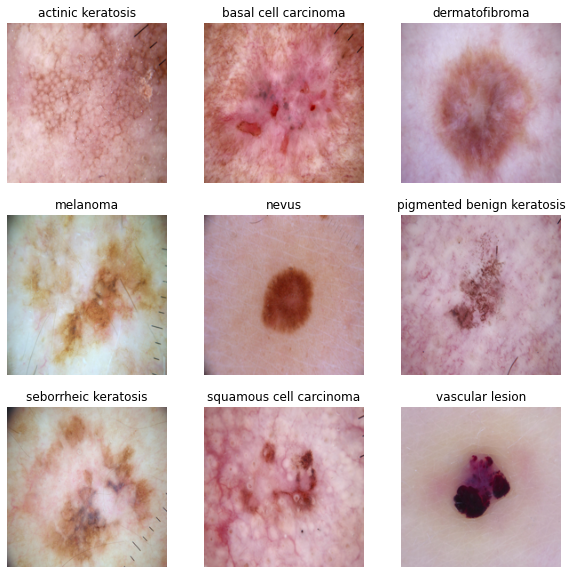

In [57]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,10))

for i in range(9):
  ax=plt.subplot(3,3,i+1)
  path = original_df[original_df['Label']==class_names[i]]['Path'].iloc[0]
  image = PIL.Image.open(path).resize((180,180))
  plt.imshow(image)
  plt.title(class_names[i])
  plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [58]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [59]:
### Your code goes here
num_classes = 10

cnn_model = Sequential([
    layers.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    layers.Conv2D(16,3,padding='SAME',activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32,3,padding='SAME',activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64,3,padding='SAME',activation='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [60]:
### Todo, choose an appropirate optimiser and loss function
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [61]:
# View the summary of all layers
cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 22, 22, 64)       

### Train the model

In [62]:
epochs = 20
history = cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 29s 190ms/step - loss: 1.8796 - accuracy: 0.3258 - val_loss: 1.6156 - val_accuracy: 0.4191
Epoch 2/20
57/57 [==============================] - 7s 120ms/step - loss: 1.4801 - accuracy: 0.4878 - val_loss: 1.4573 - val_accuracy: 0.5011
Epoch 3/20
57/57 [==============================] - 7s 121ms/step - loss: 1.3410 - accuracy: 0.5354 - val_loss: 1.4461 - val_accuracy: 0.4989
Epoch 4/20
57/57 [==============================] - 7s 120ms/step - loss: 1.2595 - accuracy: 0.5581 - val_loss: 1.3368 - val_accuracy: 0.5432
Epoch 5/20
57/57 [==============================] - 7s 121ms/step - loss: 1.1608 - accuracy: 0.5913 - val_loss: 1.3485 - val_accuracy: 0.5322
Epoch 6/20
57/57 [==============================] - 7s 121ms/step - loss: 1.0584 - accuracy: 0.6305 - val_loss: 1.4240 - val_accuracy: 0.5299
Epoch 7/20
57/57 [==============================] - 7s 121ms/step - loss: 0.9709 - accuracy: 0.6455 - val_loss: 1.3761 - val_accuracy: 0.5654
Epoch

### Visualizing training results

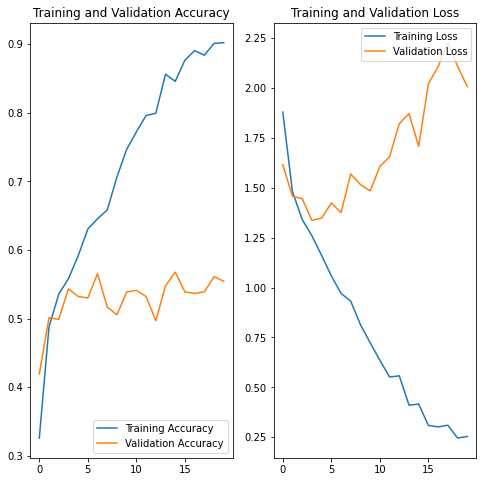

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Findings :


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Training Accuracy and Validation Accuracy increase
uniformly upto 5 Epochs but there is a sharp drop in Validation Accuracy there after. Similar behaviour is seen in Training and Validation loss, which could be due to a small set of data. A clear example of Overfitting. This prompts us to use data augmentation.





In [64]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
cnn_data_augmentation = Sequential([
        layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)                              
])

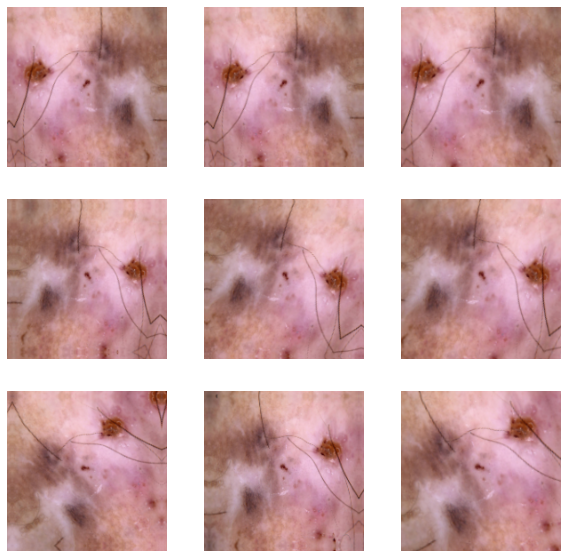

In [65]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = cnn_data_augmentation(images)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [66]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

cnn_model = Sequential([
    layers.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    layers.Conv2D(16,3,padding='SAME',activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32,3,padding='SAME',activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64,3,padding='SAME',activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(128,3,padding='SAME',activation='relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes)
])




### Compiling the model

In [67]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [68]:
cnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 22, 22, 64)       

### Training the model

In [69]:
## Your code goes here, note: train your model for 20 epochs
history = cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 9s 138ms/step - loss: 2.0182 - accuracy: 0.2522 - val_loss: 1.8342 - val_accuracy: 0.3392
Epoch 2/20
57/57 [==============================] - 8s 136ms/step - loss: 1.6887 - accuracy: 0.3816 - val_loss: 1.6093 - val_accuracy: 0.4013
Epoch 3/20
57/57 [==============================] - 8s 139ms/step - loss: 1.6291 - accuracy: 0.4165 - val_loss: 1.6224 - val_accuracy: 0.4102
Epoch 4/20
57/57 [==============================] - 8s 137ms/step - loss: 1.5167 - accuracy: 0.4530 - val_loss: 1.4821 - val_accuracy: 0.4568
Epoch 5/20
57/57 [==============================] - 8s 136ms/step - loss: 1.4279 - accuracy: 0.5039 - val_loss: 1.4751 - val_accuracy: 0.4878
Epoch 6/20
57/57 [==============================] - 8s 136ms/step - loss: 1.3463 - accuracy: 0.5149 - val_loss: 1.3701 - val_accuracy: 0.5144
Epoch 7/20
57/57 [==============================] - 8s 137ms/step - loss: 1.2888 - accuracy: 0.5409 - val_loss: 1.5655 - val_accuracy: 0.4878
Epoch 

### Visualizing the results

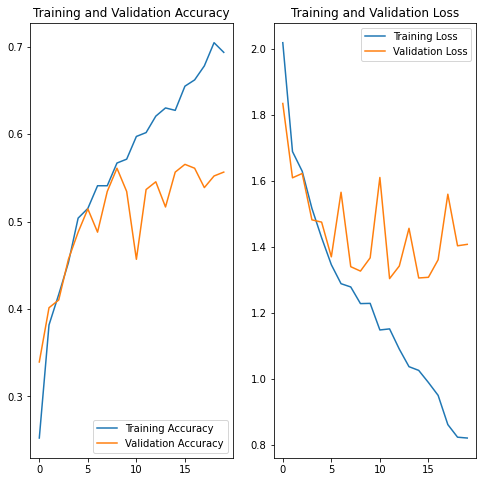

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

With the data augmentation practice and dropouts, we see a significant improvement in the gap between Training Accuracy and Validation Accuracy as compared to earlier plot. Same can be seen with Training and Validation loss, an improvement in the gap compared to earlier plot. Still there is some Overfitting due to class imbalance that we could curtail with data augmentation.

It is observed that there is a huge effect on the accuracy of the model, even though it seems like it is not overfitting, seems like if we were to run the model for more epochs there still might be some kind of overfitting, since the gap seems to just be opening up .


We can also see that even though our validation accuracy is increasing, the validation loss keeps increasing, this also tells us that we are making huge errors on the missclassified images.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [71]:
original_df['Label'].value_counts()

pigmented benign keratosis    472
melanoma                      438
basal cell carcinoma          376
nevus                         367
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? 


> Seborrheic Keratosis


#### - Which classes dominate the data in terms proportionate number of samples?


> Pigmented Benign Keratosis




#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [72]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [74]:
path_to_training_dataset="/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset +'/'+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5A3DC277D0>: 100%|██████████| 500/500 [00:02<00:00, 171.64 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5A3DFB2A90>: 100%|██████████| 500/500 [00:02<00:00, 170.57 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5A3E045090>: 100%|██████████| 500/500 [00:02<00:00, 175.25 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F5A3C555910>: 100%|██████████| 500/500 [00:09<00:00, 52.69 Samples/s] 


Initialised with 367 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F5A3DDAA850>: 100%|██████████| 500/500 [00:06<00:00, 73.08 Samples/s] 


Initialised with 472 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5A3C112250>: 100%|██████████| 500/500 [00:03<00:00, 165.23 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5A3CF01150>: 100%|██████████| 500/500 [00:03<00:00, 126.58 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5A3C32A6D0>: 100%|██████████| 500/500 [00:03<00:00, 141.77 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5A3D0EF690>: 100%|██████████| 500/500 [00:03<00:00, 165.55 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [77]:
import glob
image_count_train = len(list(cnn_data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [78]:
import glob
path_list_new = [x for x in glob.glob(os.path.join(cnn_data_dir_train, '*','output', '*.jpg'))]
print(path_list_new)

['/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010302.jpg_d8fc8cc3-f043-4b01-b76c-57023bdc83ec.jpg', '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010785.jpg_8d2ec3ad-ffc2-4b3a-b8c1-d77fd104940d.jpg', '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000165.jpg_ae39370f-2971-4282-97f4-333fe4755247.jpg', '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010993.jpg_ca0dc768-a435-4e80-ab52-24aada4110c2.jpg', '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011193.jpg_a218ad80-d099-49da-b21c-774f6f802eaa.jpg', '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imagi

In [79]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in path_list_new]
print(lesion_list_new)

['melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma', 'me

In [80]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [81]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [82]:
new_df['Label'].value_counts()

pigmented benign keratosis    972
melanoma                      938
basal cell carcinoma          876
nevus                         867
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

Now we added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [83]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [88]:
cnn_data_dir_train="/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  cnn_data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6759 files belonging to 9 classes.
Using 5408 files for training.


#### **Todo:** Create a validation dataset

In [90]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  cnn_data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6759 files belonging to 9 classes.
Using 1351 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [91]:
CNN_AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=CNN_AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=CNN_AUTOTUNE)

In [92]:
cnn_model = Sequential([
    layers.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    layers.Conv2D(16,3,padding='SAME',activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32,3,padding='SAME',activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64,3,padding='SAME',activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(128,3,padding='SAME',activation='relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [93]:
## your code goes here
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [94]:
cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 22, 22, 64)       

#### **Todo:**  Train your model

In [95]:
epochs = 50
## Your code goes here, use 50 epochs.
history = cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 30s 147ms/step - loss: 1.9647 - accuracy: 0.2430 - val_loss: 1.6530 - val_accuracy: 0.3768
Epoch 2/50
169/169 [==============================] - 23s 139ms/step - loss: 1.6171 - accuracy: 0.3946 - val_loss: 1.4922 - val_accuracy: 0.4130
Epoch 3/50
169/169 [==============================] - 23s 138ms/step - loss: 1.4805 - accuracy: 0.4314 - val_loss: 1.3125 - val_accuracy: 0.5019
Epoch 4/50
169/169 [==============================] - 23s 139ms/step - loss: 1.3768 - accuracy: 0.4780 - val_loss: 1.2395 - val_accuracy: 0.5315
Epoch 5/50
169/169 [==============================] - 24s 139ms/step - loss: 1.3100 - accuracy: 0.4941 - val_loss: 1.1748 - val_accuracy: 0.5463
Epoch 6/50
169/169 [==============================] - 23s 139ms/step - loss: 1.2096 - accuracy: 0.5364 - val_loss: 1.1719 - val_accuracy: 0.5500
Epoch 7/50
169/169 [==============================] - 24s 140ms/step - loss: 1.1322 - accuracy: 0.5621 - val_loss: 1.0634 - val_ac

#### **Todo:**  Visualize the model results

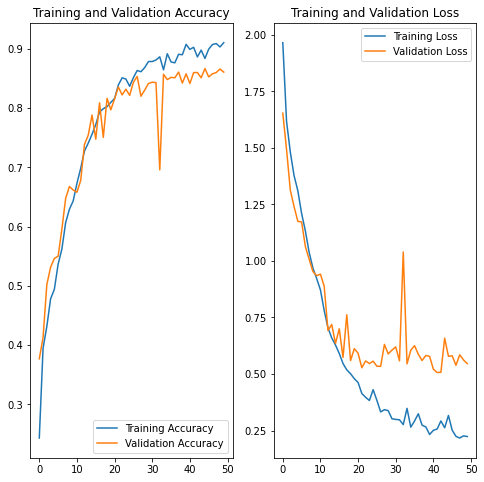

In [96]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?


We can obviously see that most of the overfitting is handled but there could be some amount of overfitting left to be handled, we can use kernal regularization, batch normalization, bias and bias regularization, add more actual data.

Rebalancing the class  helped in handling the overfitting of the model, and had a possitive impact on the model.